# DATA

## What is this notebook about

This notebook builds upon the notebook ``` spacenet6_masking.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget. 


This notebook shall be used for resizing all image input format. The available input formats will be
* PAN
* PS-RGB
* PS-RGBNIR
* RGBNIR
* SAR-Intensity

After resizing, these images will be saved to reduce the need for further processing. They will be saved in their original channel format, as a .tif file. The resized images will be read in and fed to a unet model to identify buildings. 

Functions to support data generation from all five image modes will be made available to easily generate the needed data

## Setup COLAB and imports

Mount drive to gain access to files

In [ ]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Installations required

In [ ]:
! pip install rasterio
! pip install keras_unet
! pip install focal-loss

     |████████████████████████████████| 18.2MB 165kB/s 


Imports required

In [ ]:
''' dealing with .tif files '''
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np

''' utilities '''
from tqdm import tqdm
import copy

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

''' unet model '''
from keras import backend as K
from focal_loss import BinaryFocalLoss
from keras_unet.models import satellite_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Using TensorFlow backend.


## Global

Constants and lookups - For reference the various image types are as such (amax is a rough gauge):

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     82.70110321044922     0.0
```



In [ ]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
tf.seed = seed       

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

We will be setting the amount of data that we want to use for train/test
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set for ease of verifying output 

Random indexes will be used for training and test

In [ ]:
''' set the various sizes we want to use '''
SIZE_ALL = 3401 
SIZE_TRAIN = 1600           # CHANGE HERE
SIZE_TEST = 160            # CHANGE HERE


''' Generate the indexes that we will be using for train and test '''
ALL_IDX = np.arange(SIZE_ALL)

TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
TRAIN_IDX.sort()

ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
TEST_IDX.sort()

## Helper functions

Available functions:
* ``` plot_XY(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], X_name: str, Y_name: str) : None ```
* ``` plot_XY_preds(plotname: str, X: np.dtype[SIZE], Y: np.bool[SIZE], P: np.bool[SIZE], X_name: str, Y_name: str, P_name: str) : None ```
* ``` recall_m(y_true, y_pred) : None ```
* ``` precision_m(y_true, y_pred) : None ```
* ``` f1_m(y_true, y_pred) : None ```

Various plotting functions

In [ ]:
def plot_XY(plotname, X, Y, X_name, Y_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

In [ ]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()

Define metrics for the unet models

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Generator

Available generators: 

* ``` gen_input_image_details(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP) : (IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, IMG_DTYPE: np.uint8) ```

* ``` gen_paths(IMG_TYPE: str, IMG_HEIGHT: int64, IMG_WIDTH: int64) : (PATH_SRC: PosixPath, PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_DATA: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath) ```

* ``` gen_resized_images(PATH_SRC_IMAGE: PosixPath, PATH_SRC_MASK: PosixPath, PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64) : None ```

* ``` gen_train_test_set(PATH_IMAGE: PosixPath, PATH_MASK: PosixPath, IMG_HEIGHT: int64, IMG_WIDTH: int64, IMG_CHANNELS: int64, IMG_DTYPE_SRC: np.dtype, TRAIN_IDX=TRAIN_IDX: int64[SIZE_TRAIN], TEST_IDX=TEST_IDX: int64[SIZE_TEST]) : (X_train: np.dtype[SIZE_TRAIN], Y_train: np.bool[SIZE_TRAIN], X_test: np.dtype[SIZE_TEST], Y_test: np.bool[SIZE_TEST]) ```

Reading several papers has indicated that 256x256 size is a good size for the model, hence we shall use it as the image size for now. We will set the output specifications here

In [ ]:
def gen_input_image_details(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP):
  IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
  IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
  IMG_DTYPE = np.uint8               

  return (IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE)

Setting the paths that we require, which will change based on the image type and image size specified

In [ ]:
def gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH):
  ''' set the original data source folder '''
  PATH_SRC = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')
  PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
  PATH_SRC_MASK = PATH_SRC/'_mask'


  ''' change in accordance to the image type and dimensions '''
  COMBI = IMG_TYPE + '_' + str(IMG_HEIGHT) + 'x' + str(IMG_WIDTH)


  ''' set the directories for this combination '''
  PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
  PATH_DATA.mkdir(parents=True, exist_ok=True)

  PATH_IMAGE = PATH_DATA/'image'
  PATH_IMAGE.mkdir(parents=True, exist_ok=True)

  PATH_MASK = PATH_DATA/'mask'
  PATH_MASK.mkdir(parents=True, exist_ok=True)

  return (PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK)

This will check if the required resized images have already been created. If not, it will create it.

In [ ]:
def gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH):
  def resize_and_save(img_src_path, img_fname, img_save_path):
    img = rasterio.open(img_src_path/img_fname)

    ''' use the metadata from the original image '''
    transform = img.transform
    meta = img.meta.copy()

    ''' resize the image '''
    resized_img = img.read()
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
    resized_img = reshape_as_image(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
    resized_img = reshape_as_raster(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    ''' update metadata with new size '''
    meta.update({"transform": transform,
                "height": resized_img.shape[1],
                "width": resized_img.shape[2]
                })

    ''' write the resized image to a new geotiff '''
    with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
      dst.write(resized_img)




  ''' Verify contents in source directory are present and assign to iterator '''
  src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
  src_image_ids.sort()
  # print('len(src_image_ids): {}'.format(len(src_image_ids)))
  # print(src_image_ids[:3])

  src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
  src_mask_ids.sort()
  # print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
  # print(src_mask_ids[:3])


  ''' check the target directory for existing files '''
  existing_image_ids = next(os.walk(PATH_IMAGE))[2]
  existing_image_ids.sort()
  # print('len(existing_image_ids): {}'.format(len(existing_image_ids)))
  # print(existing_image_ids[:3])

  existing_mask_ids = next(os.walk(PATH_MASK))[2]
  existing_mask_ids.sort()
  # print('len(existing_mask_ids): {}'.format(len(existing_mask_ids)))
  # print(existing_mask_ids[:3])


  ''' check if resized files already exist, else create them '''
  if (existing_image_ids == src_image_ids) and (existing_mask_ids == src_mask_ids): 
    print('Resized images and masks available')
    pass
  else:
    # print('Resizing image')
    for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
    # print('Finished resizing image')

    # print('Resizing mask')
    for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
    # print('Finished resizing mask')

    print('Resized images and masks generated')

This will return the train test set 

In [ ]:
def gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX=TRAIN_IDX, TEST_IDX=TEST_IDX):
  ''' get the ids/filenames that we need, based on the random index allocation to avoid grouping '''
  ''' X are image files, Y are mask files '''
  all_img_ids = next(os.walk(PATH_IMAGE))[2]
  all_img_ids.sort()
  all_img_ids = np.array(all_img_ids)

  all_mask_ids = next(os.walk(PATH_MASK))[2]
  all_mask_ids.sort()
  all_mask_ids = np.array(all_mask_ids)

  X_train_ids = all_img_ids[TRAIN_IDX]
  X_train_ids.sort()
  Y_train_ids = all_mask_ids[TRAIN_IDX]
  Y_train_ids.sort()

  X_test_ids = all_img_ids[TEST_IDX]
  X_test_ids.sort()
  Y_test_ids = all_mask_ids[TEST_IDX]
  Y_test_ids.sort()

  # print(len(all_img_ids))
  # print(all_img_ids[:3])
  # print(len(all_mask_ids))
  # print(all_mask_ids[:3])
  # print(len(X_train_ids))
  # print(X_train_ids[:3])
  # print(len(Y_train_ids))
  # print(Y_train_ids[:3])
  # print(len(X_test_ids))
  # print(X_test_ids[:3])
  # print(len(Y_test_ids))
  # print(Y_test_ids[:3])


  ''' prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE_SRC and mask files will be converted to np.bool '''
  X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
  Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

  # print('X_train', X_train.shape, X_train.dtype)
  # print('Y_train', Y_train.shape, Y_train.dtype)
  # print('X_test', X_test.shape, X_test.dtype)
  # print('Y_test', Y_test.shape, Y_test.dtype)

  ''' actually format the imaegs into the correct data shape and type '''
  print('formatting training images')
  for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_train[n] = img
  print('Finished formatting training images')

  print('formatting training masks')
  for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_train[n] = img
  print('Finished formatting training masks')

  print('formatting test images')
  for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_IMAGE/id).read()
    img = reshape_as_image(img)
    X_test[n] = img
  print('Finished formatting test images')

  print('formatting test masks')
  for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
    img = rasterio.open(PATH_MASK/id).read()
    img = reshape_as_image(img)
    img = img.astype(np.bool) 
    Y_test[n] = img
  print('Finished formatting test masks')  


  return (X_train, Y_train, X_test, Y_test)

# MODEL

## basic model generator

In [ ]:
def gen_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME):
  model = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)
  # model.summary()

  checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6_keras_4.h5', verbose=1, save_best_only=True)

  callbacks = [
          tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
          tf.keras.callbacks.TensorBoard(log_dir='logs')
        ]   

  results = model.fit(X_train, Y_train, validation_split=MODEL_VAL_SPLIT, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, callbacks=callbacks)        

  model.save(PATH_DATA/MODEL_NAME)  

  return model

## satellite_unet: PAN images

### Obtain our train/test set

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PAN', 256, 256)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
X_train, Y_train, X_test, Y_test = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC)

Resized images and masks available


  0%|          | 0/1600 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/1600 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting test images
formatting test masks


100%|██████████| 160/160 [00:52<00:00,  3.05it/s]

Finished formatting test masks


Verify the image conversion, and inspect the data

In [ ]:
# plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
# plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
# plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')
# plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')

### Train the model

Define model hyperparameters

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = BinaryFocalLoss(gamma=2)
MODEL_METRICS =['acc', f1_m, precision_m, recall_m]
MODEL_VAL_SPLIT = 0.1
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 15
MODEL_NAME = 'MODEL_satellite_unet_{}_{}x{}_epoch_{}_SIZE_TRAIN_{}'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN)

Define the model

In [ ]:
model_pan = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_pan.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)
# model_pan.summary()

Define model checkpoints

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6_keras_4.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ] 

In [ ]:
results = model_pan.fit(X_train, Y_train, validation_split=MODEL_VAL_SPLIT, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, callbacks=callbacks)

Epoch 1/15
90/90 [==============================] - 79s 878ms/step - loss: 0.0568 - acc: 0.9197 - f1_m: 0.3057 - precision_m: 0.4948 - recall_m: 0.2497 - val_loss: 0.0403 - val_acc: 0.9406 - val_f1_m: 0.4523 - val_precision_m: 0.7107 - val_recall_m: 0.3337
Epoch 2/15
90/90 [==============================] - 78s 872ms/step - loss: 0.0385 - acc: 0.9415 - f1_m: 0.4772 - precision_m: 0.6569 - recall_m: 0.3995 - val_loss: 0.0359 - val_acc: 0.9460 - val_f1_m: 0.5702 - val_precision_m: 0.6952 - val_recall_m: 0.4857
Epoch 3/15
90/90 [==============================] - 80s 886ms/step - loss: 0.0334 - acc: 0.9505 - f1_m: 0.5823 - precision_m: 0.7221 - recall_m: 0.5040 - val_loss: 0.0338 - val_acc: 0.9499 - val_f1_m: 0.5373 - val_precision_m: 0.8493 - val_recall_m: 0.3937
Epoch 4/15
90/90 [==============================] - 80s 886ms/step - loss: 0.0312 - acc: 0.9538 - f1_m: 0.6183 - precision_m: 0.7461 - recall_m: 0.5437 - val_loss: 0.0317 - val_acc: 0.9534 - val_f1_m: 0.6436 - val_precision_m: 0.

In [ ]:
model_pan.save(PATH_DATA/MODEL_NAME)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/PAN_256x256/MODEL_satellite_unet_PAN_256x256_epoch_15_SIZE_TRAIN_1600/assets


### Use the trained model to do some predictions

In [ ]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model_pan.predict(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], verbose=1)
preds_val = model_pan.predict(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], verbose=1)
preds_test = model_pan.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 2s 354ms/step


index: 892
train preds  set


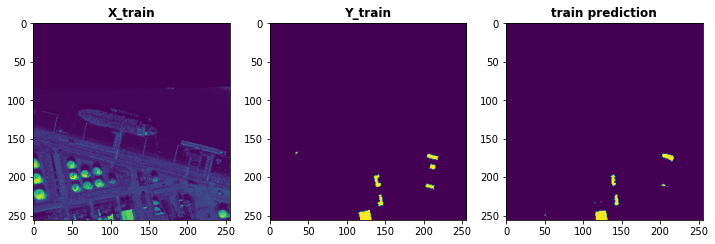

index: 47
val preds  set


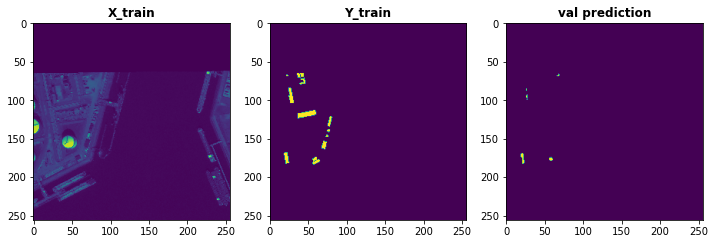

index: 126
test preds  set


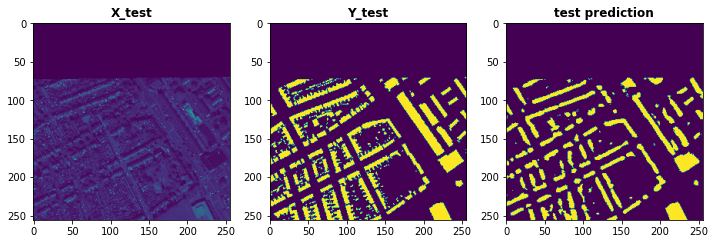

In [ ]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

Check the model metrics

In [ ]:
print("train set evaluation")
model_pan.evaluate(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))])

print("\nvalidation set evaluation")
model_pan.evaluate(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):])

print("\ntest set evaluation")
model_pan.evaluate(X_test, Y_test)

train set evaluation
45/45 [==============================] - 20s 437ms/step - loss: 0.0158 - acc: 0.9763 - f1_m: 0.8251 - precision_m: 0.8639 - recall_m: 0.7899

validation set evaluation
5/5 [==============================] - 2s 361ms/step - loss: 0.0192 - acc: 0.9714 - f1_m: 0.7946 - precision_m: 0.8486 - recall_m: 0.7475

test set evaluation
5/5 [==============================] - 2s 358ms/step - loss: 0.0183 - acc: 0.9732 - f1_m: 0.8097 - precision_m: 0.8568 - recall_m: 0.7675


[0.018285047262907028,
 0.9732389450073242,
 0.8096548318862915,
 0.8567838668823242,
 0.7674534916877747]

## satellite_unet: PS-RGB images

### Obtain our train/test set

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGB', 256, 256)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
X_train, Y_train, X_test, Y_test = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC)

  0%|          | 0/1600 [00:00<?, ?it/s]

Resized images and masks available
formatting training images


  0%|          | 0/1600 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  1%|          | 1/160 [00:00<00:28,  5.51it/s]

Finished formatting test images
formatting test masks


100%|██████████| 160/160 [00:41<00:00,  3.89it/s]

Finished formatting test masks


Verify the image conversion, and inspect the data

In [ ]:
# plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
# plot_XY('train', X_train, Y_train, 'X_train', 'Y_train')
# plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')
# plot_XY('test', X_test, Y_test, 'X_test', 'Y_test')

### Train the model

Define model hyperparameters

In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = BinaryFocalLoss(gamma=2)
MODEL_METRICS =['acc', f1_m, precision_m, recall_m]
MODEL_VAL_SPLIT = 0.1
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 15
MODEL_NAME = 'MODEL_satellite_unet_{}_{}x{}_epoch_{}_SIZE_TRAIN_{}'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN)

Define the model

In [ ]:
model_ps_rgb = satellite_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_ps_rgb.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)
# model_ps_rgb.summary()

Define model checkpoints

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_spacenet6_keras_4.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
      ] 

In [ ]:
results = model_ps_rgb.fit(X_train, Y_train, validation_split=MODEL_VAL_SPLIT, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, callbacks=callbacks)

Epoch 1/15
90/90 [==============================] - 79s 879ms/step - loss: 0.0674 - acc: 0.9104 - f1_m: 0.3079 - precision_m: 0.4997 - recall_m: 0.2716 - val_loss: 0.0413 - val_acc: 0.9326 - val_f1_m: 0.5922 - val_precision_m: 0.5339 - val_recall_m: 0.6689
Epoch 2/15
90/90 [==============================] - 80s 884ms/step - loss: 0.0342 - acc: 0.9483 - f1_m: 0.5556 - precision_m: 0.7102 - recall_m: 0.4818 - val_loss: 0.0327 - val_acc: 0.9493 - val_f1_m: 0.6548 - val_precision_m: 0.6436 - val_recall_m: 0.6694
Epoch 3/15
90/90 [==============================] - 80s 884ms/step - loss: 0.0295 - acc: 0.9564 - f1_m: 0.6421 - precision_m: 0.7633 - recall_m: 0.5648 - val_loss: 0.0318 - val_acc: 0.9519 - val_f1_m: 0.6824 - val_precision_m: 0.6637 - val_recall_m: 0.7068
Epoch 4/15
90/90 [==============================] - 80s 884ms/step - loss: 0.0296 - acc: 0.9563 - f1_m: 0.6434 - precision_m: 0.7539 - recall_m: 0.5836 - val_loss: 0.0371 - val_acc: 0.9451 - val_f1_m: 0.4218 - val_precision_m: 0.

In [ ]:
model_ps_rgb.save(PATH_DATA/MODEL_NAME)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/PS-RGB_256x256/MODEL_satellite_unet_PS-RGB_256x256_epoch_15_SIZE_TRAIN_1600/assets


### Use the trained model to do some predictions

In [ ]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model_ps_rgb.predict(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], verbose=1)
preds_val = model_ps_rgb.predict(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], verbose=1)
preds_test = model_ps_rgb.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 2s 342ms/step


index: 21
train preds  set


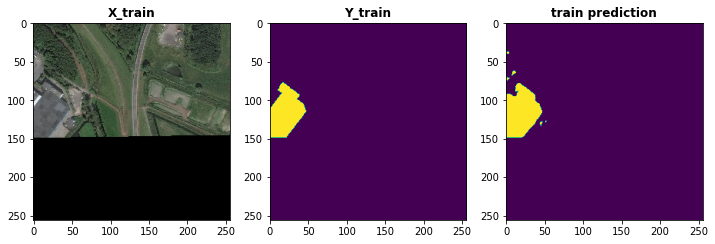

index: 142
val preds  set


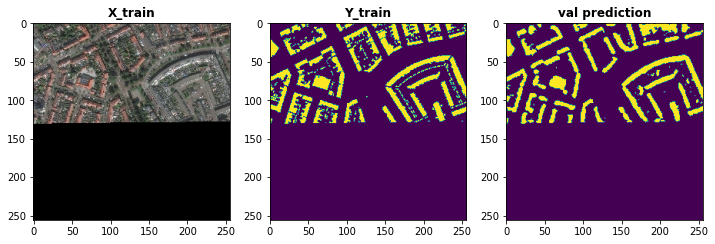

index: 100
test preds  set


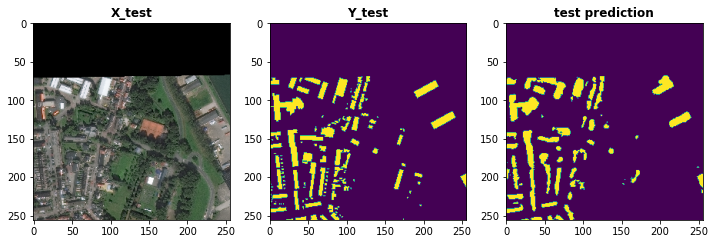

In [ ]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

Check the model metrics

In [ ]:
print("train set evaluation")
model_ps_rgb.evaluate(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))])

print("\nvalidation set evaluation")
model_ps_rgb.evaluate(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):])

print("\ntest set evaluation")
model_ps_rgb.evaluate(X_test, Y_test)

train set evaluation
45/45 [==============================] - 19s 419ms/step - loss: 0.0151 - acc: 0.9775 - f1_m: 0.8404 - precision_m: 0.8453 - recall_m: 0.8358

validation set evaluation
5/5 [==============================] - 2s 340ms/step - loss: 0.0176 - acc: 0.9737 - f1_m: 0.8200 - precision_m: 0.8286 - recall_m: 0.8121

test set evaluation
5/5 [==============================] - 2s 343ms/step - loss: 0.0171 - acc: 0.9745 - f1_m: 0.8271 - precision_m: 0.8319 - recall_m: 0.8225


[0.017095955088734627,
 0.9744815826416016,
 0.8271369934082031,
 0.8319168090820312,
 0.8224853277206421]

## satellite_unet: PS-RGBNIR images (using model generator)

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('PS-RGBNIR', 256, 256)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
X_train, Y_train, X_test, Y_test = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC)

Resized images and masks available


  0%|          | 0/1600 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/1600 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  1%|          | 1/160 [00:00<00:27,  5.70it/s]

Finished formatting test images
formatting test masks


100%|██████████| 160/160 [00:37<00:00,  4.24it/s]

Finished formatting test masks


In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = BinaryFocalLoss(gamma=2)
MODEL_METRICS =['acc', f1_m, precision_m, recall_m]
MODEL_VAL_SPLIT = 0.1
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 15
MODEL_NAME = 'MODEL_satellite_unet_{}_{}x{}_epoch_{}_SIZE_TRAIN_{}'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN)

model_ps_rgbnir = gen_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME)

Epoch 1/15
90/90 [==============================] - 79s 880ms/step - loss: 0.0535 - acc: 0.9242 - f1_m: 0.3394 - precision_m: 0.5264 - recall_m: 0.2827 - val_loss: 0.0389 - val_acc: 0.9402 - val_f1_m: 0.3900 - val_precision_m: 0.7874 - val_recall_m: 0.2596
Epoch 2/15
90/90 [==============================] - 80s 887ms/step - loss: 0.0328 - acc: 0.9490 - f1_m: 0.5637 - precision_m: 0.7174 - recall_m: 0.4957 - val_loss: 0.0312 - val_acc: 0.9534 - val_f1_m: 0.6317 - val_precision_m: 0.7536 - val_recall_m: 0.5447
Epoch 3/15
90/90 [==============================] - 80s 889ms/step - loss: 0.0286 - acc: 0.9576 - f1_m: 0.6608 - precision_m: 0.7592 - recall_m: 0.5997 - val_loss: 0.0308 - val_acc: 0.9537 - val_f1_m: 0.6382 - val_precision_m: 0.7342 - val_recall_m: 0.5684
Epoch 4/15
90/90 [==============================] - 80s 890ms/step - loss: 0.0261 - acc: 0.9614 - f1_m: 0.6941 - precision_m: 0.7840 - recall_m: 0.6373 - val_loss: 0.0264 - val_acc: 0.9607 - val_f1_m: 0.6661 - val_precision_m: 0.

### Use the trained model to do some predictions

In [ ]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model_ps_rgbnir.predict(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], verbose=1)
preds_val = model_ps_rgbnir.predict(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], verbose=1)
preds_test = model_ps_rgbnir.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 2s 349ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 27
train preds  set


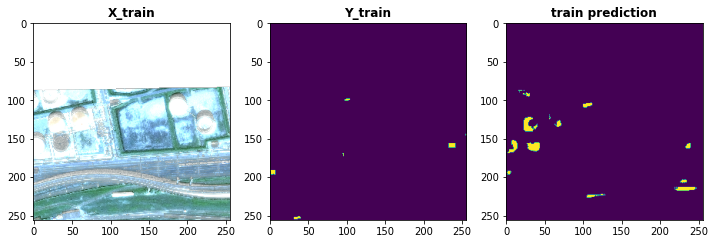

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 52
val preds  set


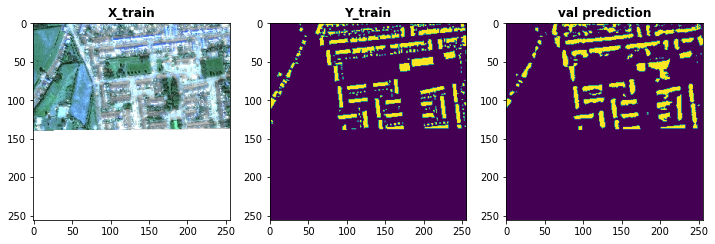

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 77
test preds  set


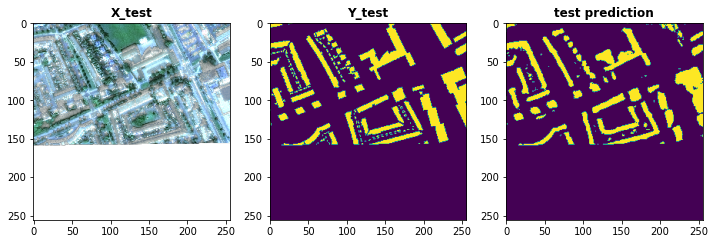

In [ ]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

Check the model metrics

In [ ]:
print("train set evaluation")
model_ps_rgbnir.evaluate(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))])

print("\nvalidation set evaluation")
model_ps_rgbnir.evaluate(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):])

print("\ntest set evaluation")
model_ps_rgbnir.evaluate(X_test, Y_test)

train set evaluation
45/45 [==============================] - 19s 430ms/step - loss: 0.0177 - acc: 0.9736 - f1_m: 0.8090 - precision_m: 0.8239 - recall_m: 0.7948

validation set evaluation
5/5 [==============================] - 2s 355ms/step - loss: 0.0202 - acc: 0.9699 - f1_m: 0.7914 - precision_m: 0.8091 - recall_m: 0.7746

test set evaluation
5/5 [==============================] - 2s 351ms/step - loss: 0.0193 - acc: 0.9713 - f1_m: 0.8020 - precision_m: 0.8174 - recall_m: 0.7874


[0.019338062033057213,
 0.9712985754013062,
 0.8020389676094055,
 0.8174432516098022,
 0.7873808145523071]

## satellite_unet: RGBNIR images (using model generator)

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('RGBNIR', 256, 256)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
X_train, Y_train, X_test, Y_test = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC)

Resized images and masks available


  0%|          | 0/1600 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/1600 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  1%|          | 1/160 [00:00<00:29,  5.33it/s]

Finished formatting test images
formatting test masks


100%|██████████| 160/160 [00:36<00:00,  4.37it/s]

Finished formatting test masks


In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = BinaryFocalLoss(gamma=2)
MODEL_METRICS =['acc', f1_m, precision_m, recall_m]
MODEL_VAL_SPLIT = 0.1
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 15
MODEL_NAME = 'MODEL_satellite_unet_{}_{}x{}_epoch_{}_SIZE_TRAIN_{}'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN)

model_rgbnir = gen_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME)

Epoch 1/15
90/90 [==============================] - 80s 888ms/step - loss: 0.0509 - acc: 0.9278 - f1_m: 0.4403 - precision_m: 0.5625 - recall_m: 0.3903 - val_loss: 0.0338 - val_acc: 0.9536 - val_f1_m: 0.6075 - val_precision_m: 0.7930 - val_recall_m: 0.4951
Epoch 2/15
90/90 [==============================] - 80s 889ms/step - loss: 0.0302 - acc: 0.9549 - f1_m: 0.6351 - precision_m: 0.7386 - recall_m: 0.5755 - val_loss: 0.0310 - val_acc: 0.9561 - val_f1_m: 0.6561 - val_precision_m: 0.7747 - val_recall_m: 0.5697
Epoch 3/15
90/90 [==============================] - 80s 889ms/step - loss: 0.0270 - acc: 0.9601 - f1_m: 0.6876 - precision_m: 0.7695 - recall_m: 0.6357 - val_loss: 0.0485 - val_acc: 0.9558 - val_f1_m: 0.6716 - val_precision_m: 0.7308 - val_recall_m: 0.6276
Epoch 4/15
90/90 [==============================] - 80s 890ms/step - loss: 0.0264 - acc: 0.9614 - f1_m: 0.6975 - precision_m: 0.7753 - recall_m: 0.6444 - val_loss: 0.0256 - val_acc: 0.9623 - val_f1_m: 0.7357 - val_precision_m: 0.

### Use the trained model to do some predictions

In [ ]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model_rgbnir.predict(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], verbose=1)
preds_val = model_rgbnir.predict(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], verbose=1)
preds_test = model_rgbnir.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5/5 [==============================] - 2s 349ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 1429
train preds  set


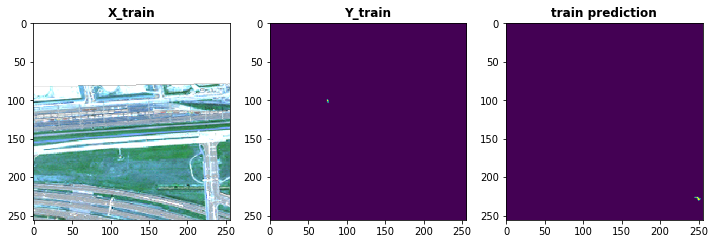

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 107
val preds  set


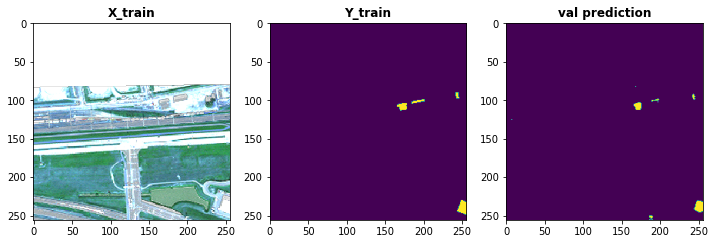

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index: 139
test preds  set


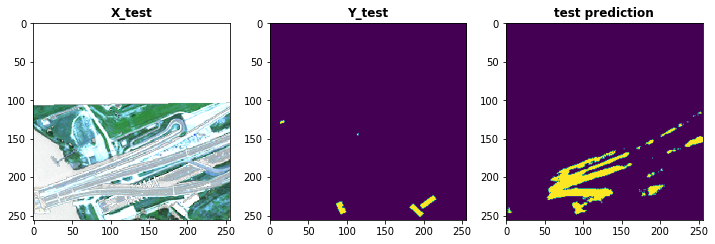

In [ ]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

Check the model metrics

In [ ]:
print("train set evaluation")
model_rgbnir.evaluate(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))])

print("\nvalidation set evaluation")
model_rgbnir.evaluate(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):])

print("\ntest set evaluation")
model_rgbnir.evaluate(X_test, Y_test)

train set evaluation
45/45 [==============================] - 19s 431ms/step - loss: 0.0230 - acc: 0.9658 - f1_m: 0.7708 - precision_m: 0.7253 - recall_m: 0.8232

validation set evaluation
5/5 [==============================] - 2s 352ms/step - loss: 0.0255 - acc: 0.9628 - f1_m: 0.7585 - precision_m: 0.7196 - recall_m: 0.8031

test set evaluation
5/5 [==============================] - 2s 350ms/step - loss: 0.0259 - acc: 0.9618 - f1_m: 0.7586 - precision_m: 0.7116 - recall_m: 0.8128


[0.025889163836836815,
 0.9618489146232605,
 0.7586070895195007,
 0.7115551233291626,
 0.8127579689025879]

## satellite_unet: SAR-Intensity images (using model generator)
### we run out of memory during the training process because SAR data comes in as float32

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', 256, 256)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK = gen_paths(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH)
X_train, Y_train, X_test, Y_test = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_DTYPE_SRC)

Resized images and masks available


  0%|          | 0/1600 [00:00<?, ?it/s]

formatting training images


  0%|          | 0/1600 [00:00<?, ?it/s]

Finished formatting training images
formatting training masks


  0%|          | 0/160 [00:00<?, ?it/s]

Finished formatting training masks
formatting test images


  1%|          | 1/160 [00:00<00:30,  5.26it/s]

Finished formatting test images
formatting test masks


100%|██████████| 160/160 [00:36<00:00,  4.38it/s]

Finished formatting test masks


In [ ]:
MODEL_OPTIMIZER = 'adam'
MODEL_LOSS = BinaryFocalLoss(gamma=2)
MODEL_METRICS =['acc', f1_m, precision_m, recall_m]
MODEL_VAL_SPLIT = 0.1
MODEL_BATCH_SIZE = 16
MODEL_EPOCHS = 15
MODEL_NAME = 'MODEL_satellite_unet_{}_{}x{}_epoch_{}_SIZE_TRAIN_{}'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, MODEL_EPOCHS, SIZE_TRAIN)

model_sar = gen_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, X_train, Y_train, MODEL_VAL_SPLIT, MODEL_BATCH_SIZE, MODEL_EPOCHS, PATH_DATA, MODEL_NAME)

Epoch 1/15


ResourceExhaustedError: ignored

### Use the trained model to do some predictions

In [ ]:
''' split train, val 90-10. validation_split takes the percentage from the back '''
preds_train = model_sar.predict(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], verbose=1)
preds_val = model_sar.predict(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], verbose=1)
preds_test = model_sar.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
plot_XY_preds('train preds', X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], preds_val_t, 'X_train', 'Y_train', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')

Check the model metrics

In [ ]:
print("train set evaluation")
model_sar.evaluate(X_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))], Y_train[:int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT))])

print("\nvalidation set evaluation")
model_sar.evaluate(X_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):], Y_train[int(X_train.shape[0]*(1 - MODEL_VAL_SPLIT)):])

print("\ntest set evaluation")
model_sar.evaluate(X_test, Y_test)